# Data Engineering setup for Part 1



In [55]:
# Importing necessary libraries for data cleaning and exploration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [56]:
# Load the dataset
df = pd.read_csv('Data/QF632_Project_1.csv')

# Examine the structure and summary
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038 entries, 0 to 1037
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1038 non-null   object 
 1   Signal     1038 non-null   float64
 2   Open       1038 non-null   float64
 3   High       1038 non-null   float64
 4   Low        1038 non-null   float64
 5   Close      1038 non-null   float64
 6   Adj Close  1038 non-null   float64
dtypes: float64(6), object(1)
memory usage: 56.9+ KB
None
            Signal         Open         High          Low        Close  \
count  1038.000000  1038.000000  1038.000000  1038.000000  1038.000000   
mean     16.766190   141.847360   142.691801   140.907746   141.840973   
std       3.095783    18.475574    18.470255    18.404504    18.497010   
min       0.000000    94.080002    95.400002    93.639999    94.790001   
25%      14.691150   132.132496   132.912495   130.542503   131.824993   
50%      17.298240   146.769997 

# Table of Contents <a name="tableofcontents"></a>
1. [Review the quality of the data, list any potential errors, and propose corrected values. Please list each quality check error and correction applied.](#part1)
2. [Please analyze the signal’s effectiveness or lack thereof in forecasting ETF price, using whatever metrics you think are most relevant.](#part2)
3. [Run any exploratory data analysis you think is important and highlight any interesting insights you come across. ](#part3)

# part1 
Review the quality of the data, list any potential errors, and propose corrected values. Please list each quality check error and correction applied.

a.	Check object types

b.	Check for nan values

    i.	Interpolate or forward fill. If interpolate, be careful not to include future rows 

c.	Difference all first

d.	Scatter plot/boxplot for outliers

    i.	See if need outlier handling (If no, maybe justify why)


In [57]:
def length_test(df):
    """
    Check the length of the dataset.
    
    Returns:
        bool: True if the dataframe is not empty, False otherwise.
    """
    return len(df) > 0

In [58]:
def missing_test(df):
    """
    Check for missing values in the dataframe.
    
    Returns:
        bool: True if there are missing values, False otherwise.
    """
    # return df.isnull().sum() > 0
    return df.isnull().values.any()

In [59]:
def duplicate_test(df):
    """
    Check for duplicated rows in the dataframe.
    
    Returns:
        bool: True if no duplicates are found, False otherwise.
        pd.DataFrame: Dataframe with duplicates dropped if any were found.
    """
    duplicated_rows = df[df.duplicated()]
    result = duplicated_rows.empty
    if not result:
        df = df.drop_duplicates()
    return result, df

In [60]:
def date_test(df):
    """
    Ensure dates are in the right format and sequence.
    
    Returns:
        bool: True if all dates are valid, False otherwise.
    """
    date_check = df['Date'].apply(pd.to_datetime, errors='coerce').isnull().sum()
    return date_check == 0

In [61]:
def datatype_test(df):
    """
    Checks if the data types in the dataframe match the expected types.

    Args:
        df (pd.DataFrame): The dataframe to check.
        expected_types (dict): A dictionary mapping column names to 
            expected data types (e.g., {'Date': 'datetime64[ns]', 'Price': 'float64'})

    Returns:
        tuple: (bool, list, pd.DataFrame) - 
            True if all data types match, False otherwise.
            A list of error messages for mismatched data types.
            The dataframe with corrected data types.
    """
   # Expected data types
    expected_types = {
        'Date': 'datetime64[ns]',
        'Signal': 'float64',
        'Open': 'float64',
        'High': 'float64',
        'Low': 'float64',
        'Close': 'float64',
        'Adj Close': 'float64',
    }
    errors = []
    for col, expected_type in expected_types.items():
        if col in df.columns:
            if df[col].dtype != expected_type:
                errors.append(f"Column '{col}' is of type {df[col].dtype} but expected {expected_type}.")
                # Attempt conversion with coerce
                try:
                    if expected_type == 'datetime64[ns]':
                        df[col] = pd.to_datetime(df[col], errors='coerce')
                    else:
                        df[col] = pd.to_numeric(df[col], errors='coerce').astype(expected_type)
                except Exception as e:
                    errors.append(f"Failed to convert column '{col}' to {expected_type}: {e}")
    return len(errors) == 0, errors, df

In [62]:
def nan_values_test(df):
    """
    Check for NaN values and handle them.
    
    Returns:
        list: List of error messages for columns containing NaN values.
        pd.DataFrame: Dataframe with NaN values handled.
    """
    errors = []
    nan_summary = df.isna().sum()
    nan_columns = nan_summary[nan_summary > 0].index.tolist()
    
    for column in nan_columns:
        errors.append(f"Column '{column}' has {nan_summary[column]} NaN values.")
        df[column] = df[column].interpolate(method='linear', limit_direction='forward').fillna(method='ffill')
    
    return errors, df

In [63]:
def non_positive_test(df):
    """
    Check for non-positive values in numeric columns.
    
    Returns:
        bool: True if all values are positive, False otherwise.
        dict: Dictionary with counts of non-positive values per column.
    """
    columns = [col for col in df.columns if col != 'Date']
    non_positive_values = {col: (df[col] <= 0).sum() for col in columns}
    result = all(value == 0 for value in non_positive_values.values())
    return result, non_positive_values

non_positive_check, non_positive_values = non_positive_test(df)

print(f'non_positive_check: {non_positive_check}')
print(f'non_positive_values: {non_positive_values}')

non_positive_check: False
non_positive_values: {'Signal': 6, 'Open': 0, 'High': 0, 'Low': 0, 'Close': 0, 'Adj Close': 1}


In [64]:
# Review the quality of the data
def review_data_quality(df):
    errors = []
    
    # Length test
    if not length_test(df):
        errors.append("Dataframe is empty.")
    
    # Missing values test
    if missing_test(df):
        errors.append("Dataframe contains missing values.")
    
    # Duplicate test
    duplicates_check, df = duplicate_test(df)
    if not duplicates_check:
        errors.append("Dataframe contained duplicates. Duplicates have been removed.")
    
    # Date test
    if not date_test(df):
        errors.append("Dataframe contains invalid dates.")
    
    # Data type test and correction
    datatype_check, datatype_errors, df = datatype_test(df)
    errors.extend(datatype_errors)
    
    # NaN values test and correction
    nan_errors, df = nan_values_test(df)
    errors.extend(nan_errors)
    
    # Non-positive values test
    non_positive_check, non_positive_values = non_positive_test(df)
    if not non_positive_check:
        for col, count in non_positive_values.items():
            if count > 0:
                errors.append(f"Column '{col}' contains {count} non-positive values.")

    return errors, df

In [65]:
# Difference all columns except Date
def difference_columns(df):
    df_diff = df.copy()
    df_diff.iloc[:, 1:] = df_diff.iloc[:, 1:].diff()
    return df_diff.dropna()

In [66]:
# Main cleaning function
def clean_data(file_path):
    # Load data
    df = pd.read_csv(file_path)
    
    # Review data quality and apply corrections
    errors, df_cleaned = review_data_quality(df)
    
    # Difference all columns except Date
    df_diff = difference_columns(df_cleaned)
    
    return errors, df_cleaned, df_diff

In [67]:
# Usage example
errors, df_cleaned, df_diff = clean_data('Data/QF632_Project_1.csv')

print('df_cleaned length', len(df_cleaned))
print('df_diff length', len(df_diff))

df_cleaned length 1038
df_diff length 1037


In [68]:
# Output the results
print("Data Quality Errors and Corrections:")
for error in errors:
    print(error)

Data Quality Errors and Corrections:
Column 'Date' is of type object but expected datetime64[ns].
Column 'Signal' contains 6 non-positive values.
Column 'Adj Close' contains 1 non-positive values.


In [69]:
print("\nCleaned Data:")
print(df_cleaned.info())
print(df_cleaned.describe())


Cleaned Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038 entries, 0 to 1037
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1038 non-null   datetime64[ns]
 1   Signal     1038 non-null   float64       
 2   Open       1038 non-null   float64       
 3   High       1038 non-null   float64       
 4   Low        1038 non-null   float64       
 5   Close      1038 non-null   float64       
 6   Adj Close  1038 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 56.9 KB
None
            Signal         Open         High          Low        Close  \
count  1038.000000  1038.000000  1038.000000  1038.000000  1038.000000   
mean     16.766190   141.847360   142.691801   140.907746   141.840973   
std       3.095783    18.475574    18.470255    18.404504    18.497010   
min       0.000000    94.080002    95.400002    93.639999    94.790001   
25%      14.691150   

In [70]:
print("\nDifferenced Data:")
print(df_diff.info())
print(df_diff.describe())


Differenced Data:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1037 entries, 1 to 1037
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1037 non-null   datetime64[ns]
 1   Signal     1037 non-null   float64       
 2   Open       1037 non-null   float64       
 3   High       1037 non-null   float64       
 4   Low        1037 non-null   float64       
 5   Close      1037 non-null   float64       
 6   Adj Close  1037 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 64.8 KB
None
            Signal         Open         High          Low        Close  \
count  1037.000000  1037.000000  1037.000000  1037.000000  1037.000000   
mean     -0.013277     0.045718     0.047146     0.046094     0.047531   
std       1.354861     1.411348     1.199491     1.346795     2.237763   
min     -20.016643    -8.300003    -7.030008    -5.649994   -40.039994   
25%      -0.55167

# Plotting


In [71]:
# Identify outliers using IQR method
def identify_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (series < lower_bound) | (series > upper_bound)

In [72]:
# Plotting functions for outlier detection
def plot_outliers(df):
    numeric_columns = df.select_dtypes(include=['float64']).columns

    # Scatter plots with outliers highlighted
    for column in numeric_columns:
        plt.figure(figsize=(10, 6))
        plt.scatter(df['Date'], df[column], alpha=0.5, label='Data')
        
        # Identify and plot outliers
        outliers = identify_outliers(df[column])
        plt.scatter(df['Date'][outliers], df[column][outliers], color='red', label='Outliers')
        
        plt.title(f'Scatter Plot of {column} over Time')
        plt.xlabel('Date')
        plt.ylabel(column)
        plt.legend()
        plt.show()

    # Box plots
    plt.figure(figsize=(15, 10))
    df[numeric_columns].boxplot()
    plt.title('Box Plot of Numeric Columns')
    plt.xticks(rotation=45)
    plt.show()

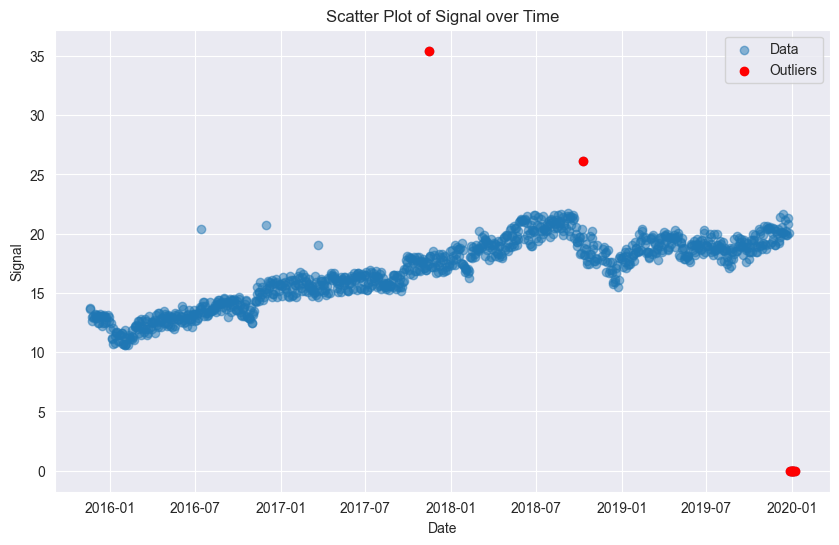

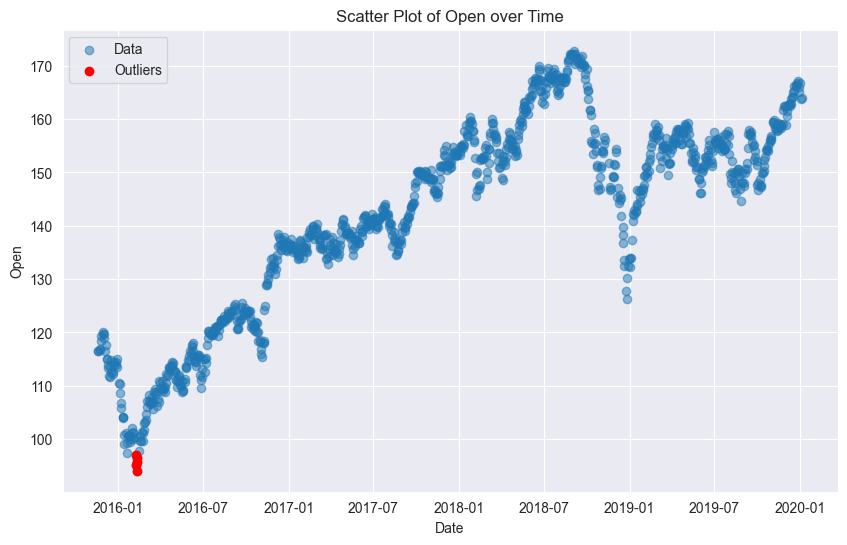

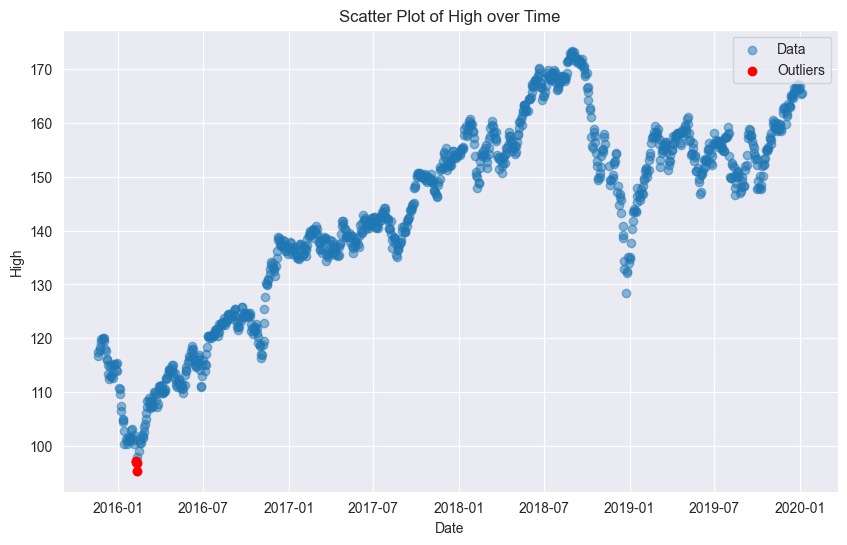

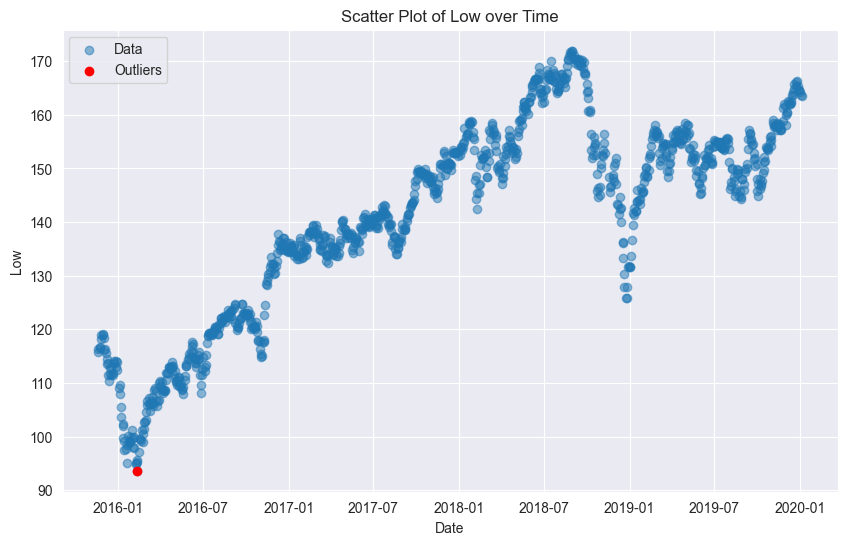

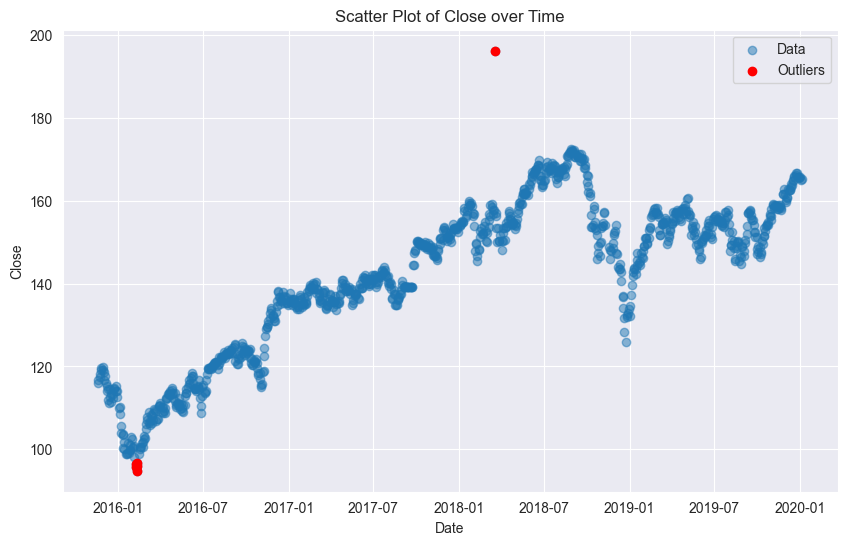

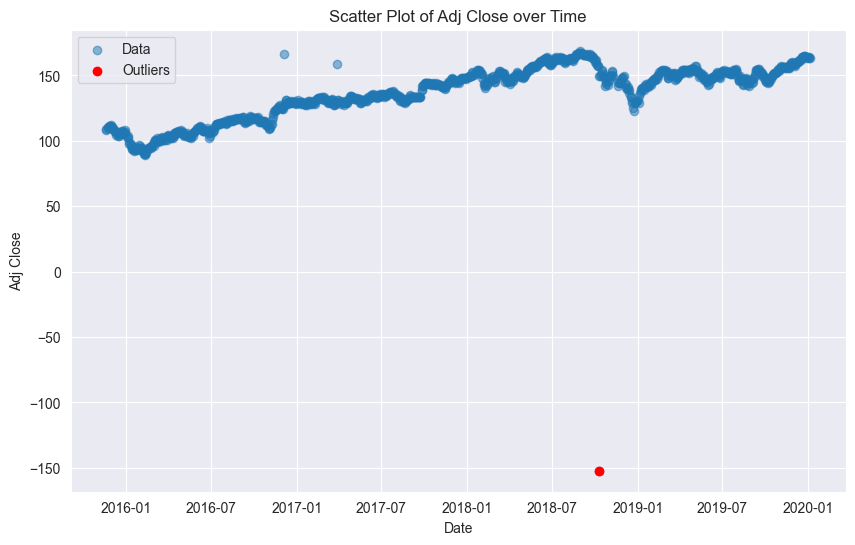

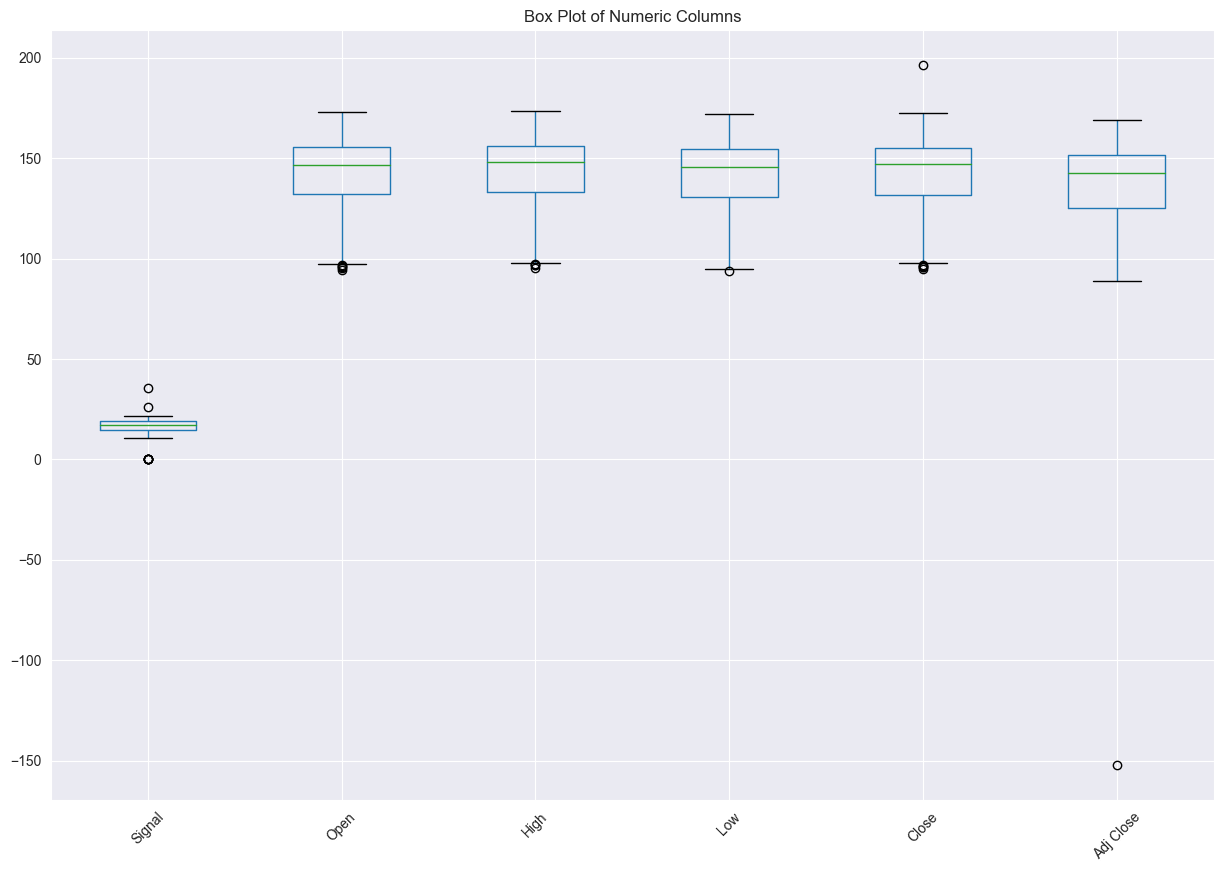

In [73]:
# Plotting outliers

plot_outliers(df_cleaned)
# TimeSeries price
# Continuous Nature:
# Time series price data is typically continuous during regular trading hours, meaning there should not have large, abrupt changes from one point to the next during this period.
# 
# After-Hours Trading:
# Prices can exhibit significant gaps between the closing price of one day and the opening price of the next trading day due to after-hours trading activities, news, earnings reports, and other factors.
# These gaps can appear as outliers when the data is visualized or analyzed.

# part2
Please analyze the signal’s effectiveness or lack thereof in forecasting ETF price, using whatever metrics you think are most relevant.


a.	Cross correlation

b.	Kurtosis & skew

c.	R2 score from Lasso, Ridge & RandomForest

d.	ACF, PACF of signal, ETF


# part3 
Run any exploratory data analysis you think is important and highlight any interesting insights you come across.

a.	Uhhh same as parts 1 &2 unless yall can think of smth else


[Return to the Top](#part1-)